# Spaceship Titanic usando Floresta Aleatória

Nesse notebook, vamos fazer uma análise exploratória dos dados presentes no dataset Spaceship Titanic. Depois, vamos treinar um modelo de Floresta Aleatória para prever quais passageiros foram transportados para outra dimensão pela anomalia. Os dados foram retirados do [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data).

Aqui será mostrada a solução mais simples e rápida para obtermos um arquivo para ser submetido no Kaggle.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sys
import logging
logging.disable(sys.maxsize)

### Carregando os dados

In [93]:
import os
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [94]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [95]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


A primeira etapa na análise exploratória será definir os tipos de dados de cada coluna, e se são relevantes para uma análise preditiva.

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [97]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Análise exploratória

Nós temos variáveis relevantes numéricas, booleanas e categóricas. A próxima etapa é verificar como as variáveis se comportam em relação à variável alvo.

Primeiramente vamos elaborar histogramas para avaliar a distribuição dos dados numéricos.

In [98]:
# separar apenas os dados numéricos
train_num = train.select_dtypes(include=['int64', 'float64'])
train_num.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


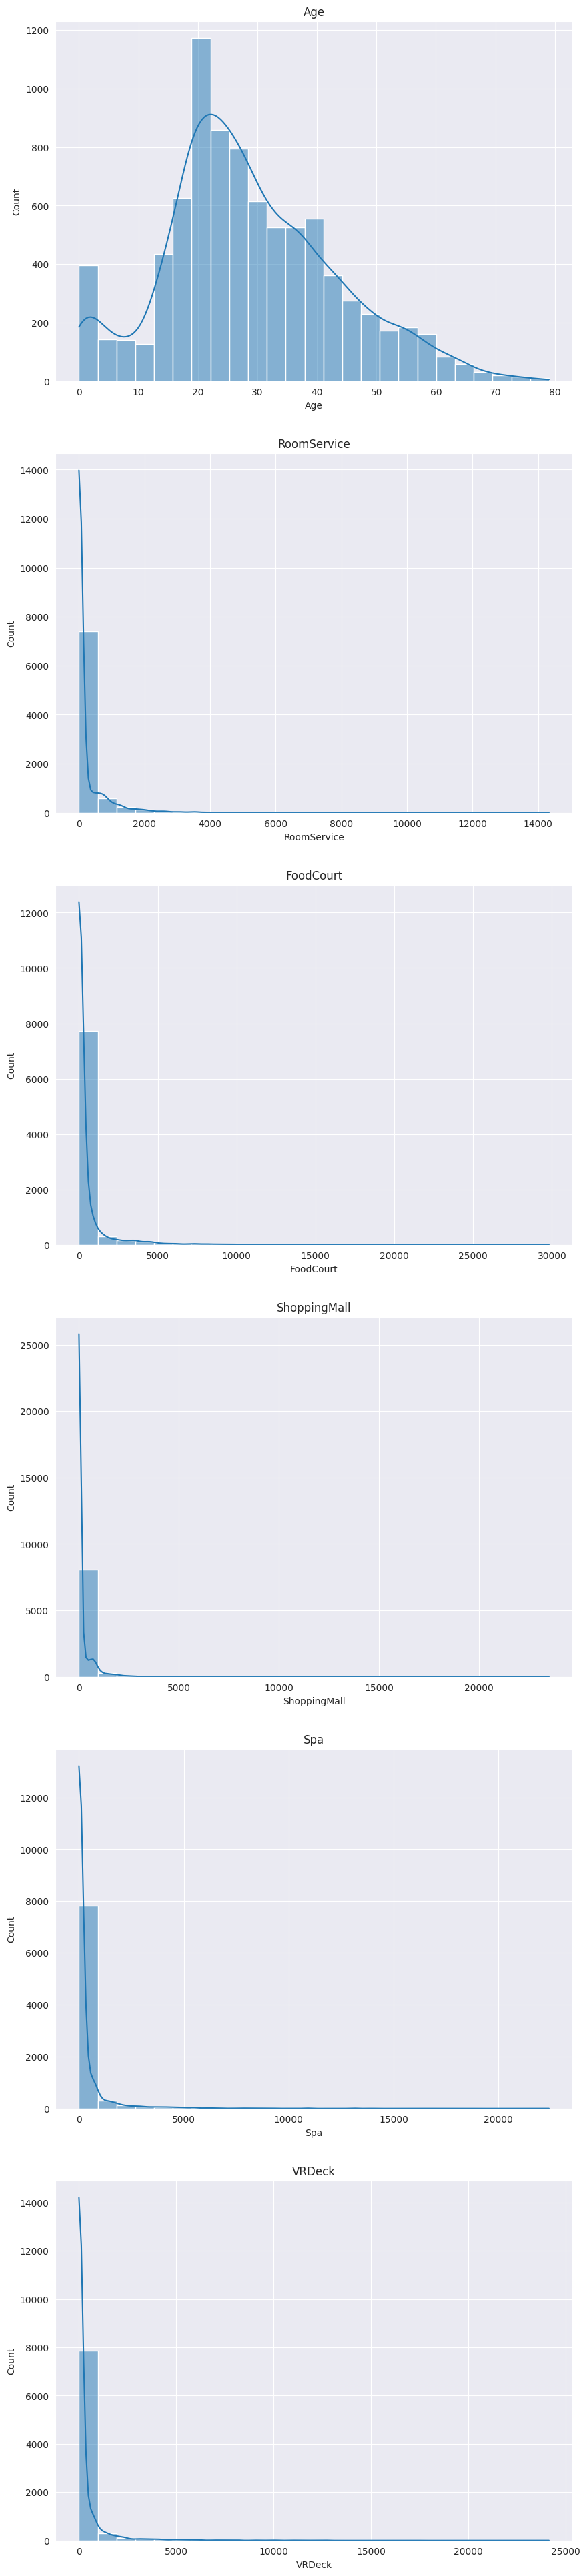

In [102]:
fig, ax = plt.subplots(6, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

for i, col in enumerate(train_num.columns):
    try:
        sns.histplot(train_num[col], ax=ax[i], bins=25, kde=True)
        ax[i].set_title(col)
    except:
        pass

Em seguida, vamos verificar o comportamento dessas variáveis numéricas em relação à variável alvo. Para isso, vamos usar um histograma sobreposto.

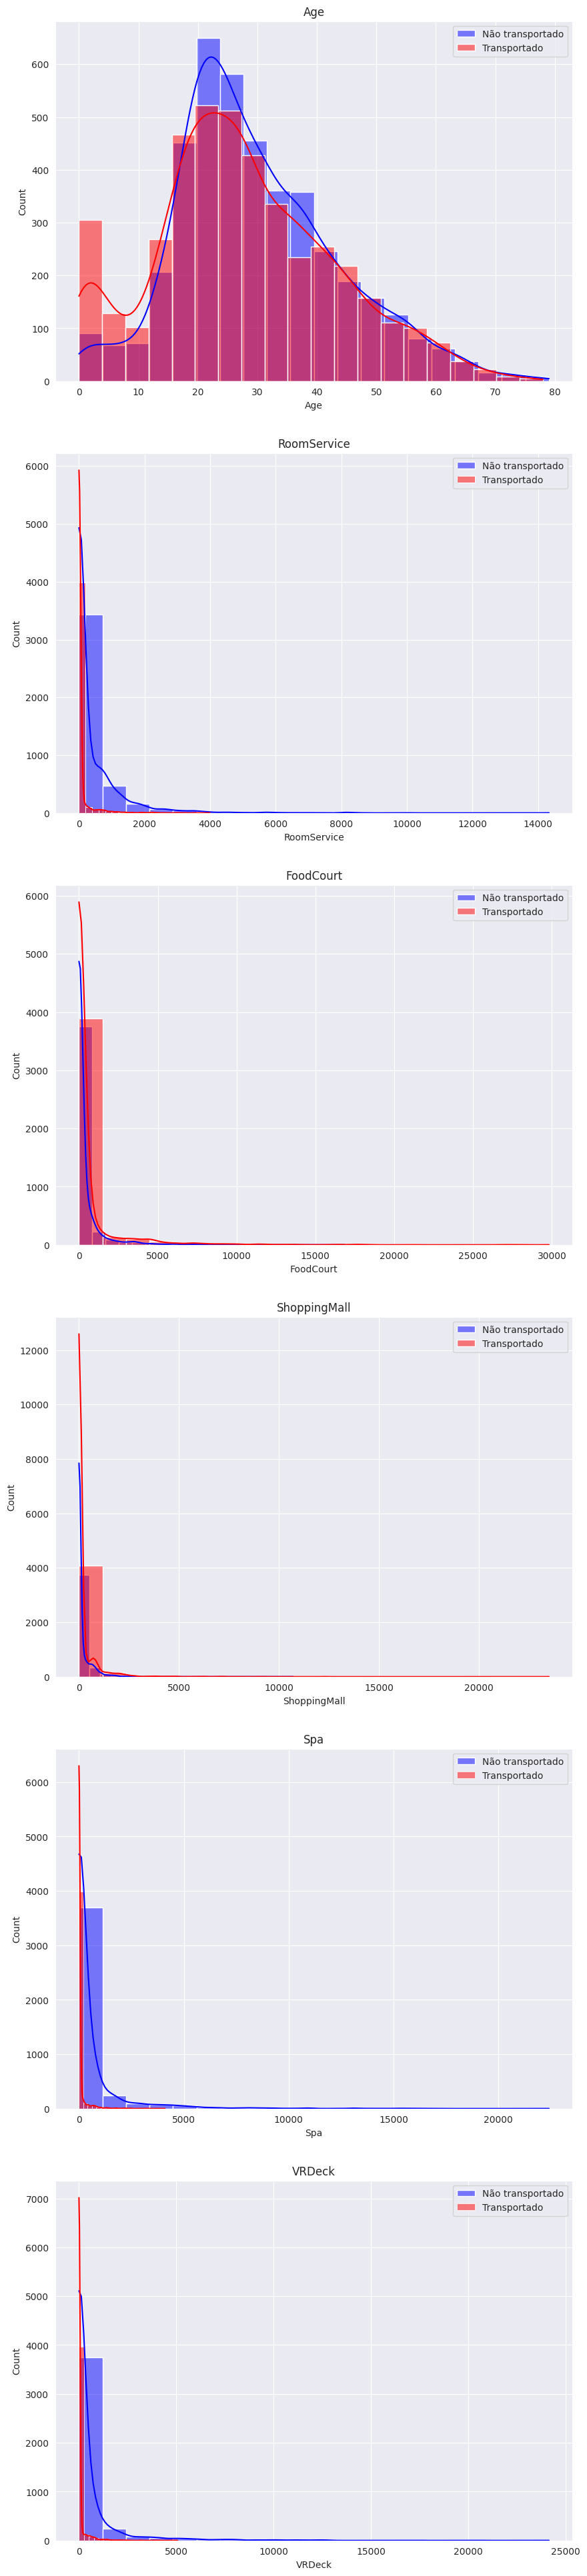

In [103]:
train_num['Transported'] = train['Transported']

fig, ax = plt.subplots(6, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

for i, col in enumerate(train_num.columns):
    try:
        sns.histplot(train_num[train_num['Transported'] == 0][col], ax=ax[i], bins=20, kde=True, color='blue', label='Não transportado')
        sns.histplot(train_num[train_num['Transported'] == 1][col], ax=ax[i], bins=20, kde=True, color='red', label='Transportado')
        ax[i].set_title(col)
        ax[i].legend()
    except:
        pass

Agora vamos verificar a relação entre as variáveis categóricas e a variável alvo. Para isso, vamos usar um gráfico de barras.

In [47]:
train_cat = train.select_dtypes(include=['object', 'bool'])
train_cat.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True


Entre as variáveis categóricas, temos algumas que aparentemente não são relevantes para a análise, como por exemplo o nome do passageiro, o seu número de identificação e o número da cabine. Vamos removê-las do dataframe para facilitar a construção das figuras.

In [105]:
try:
    train_cat = train_cat.drop(['Name', 'PassengerId', 'Cabin'], axis=1)
except:
    pass

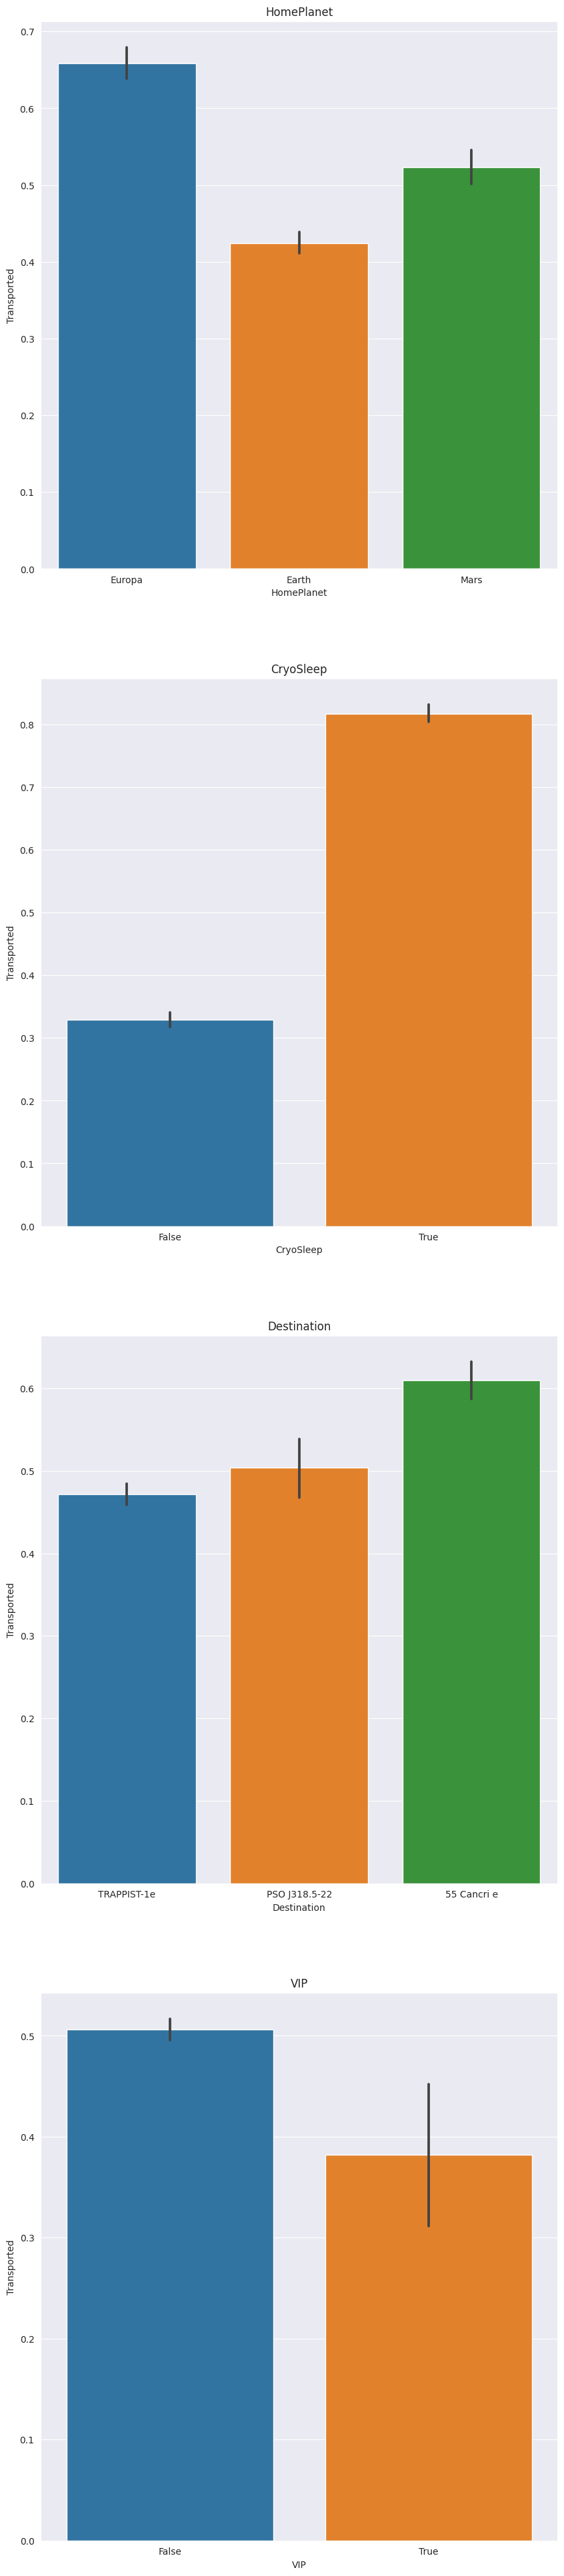

In [107]:
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
plt.subplots_adjust(top=2)

for i, col in enumerate(train_cat.columns):
    try:
        sns.barplot(x=train_cat[col], y=train_cat['Transported'], ax=ax[i])
        ax[i].set_title(col)
    except:
        pass

A partir dos gráficos elaborados é possível obter uma boa base de quais são as variáveis mais relevantes para a análise. Vamos agora verificar a correlação entre as variáveis numéricas.

In [108]:
corr = train_num.corr()
corr

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


<Axes: >

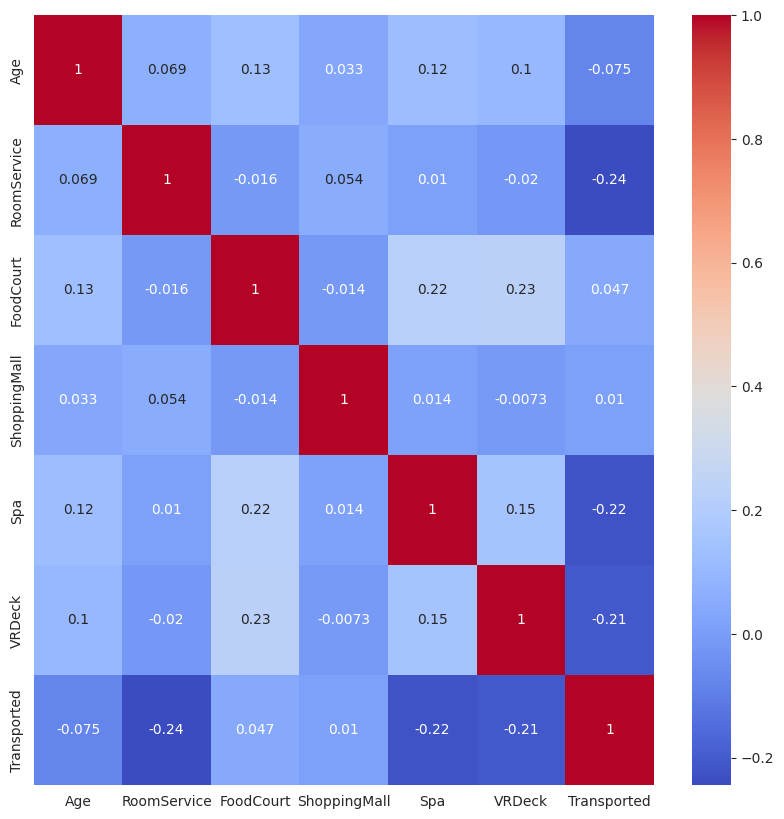

In [109]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

O heatmap de correlação também pode nos auxiliar a verificar quais variáveis podem ser consideradas mais importantes para a predição, se tratando de variáveis numéricas. A maior parte das correlações apresentadas é fraca quando se trata da variável alvo.

### Pré-processamento dos dados

Agora que já temos uma boa base de como os dados estão distribuídos, vamos prepará-los para serem utilizados no modelo de aprendizado de máquina. Primeiramente, vamos remover as variáveis que não serão utilizadas na análise. Nesse caso, vamos utilizar todas as variáveis numéricas, e as variáveis categóricas selecionadas, excluindo as que acreditamos ser irrelevantes para a análise.

In [110]:
if 'Name' in train.columns:
    train = train.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

In [111]:
if 'Name' in test.columns:
    test = test.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

In [112]:
y = train['Transported']
X = train.drop('Transported', axis=1)

Como algumas variáveis categóricas não são binárias, vamos precisar utilizar variáveis dummy para representá-las.

Para resumir, variáveis categóricas são variáveis que têm valores que correspondem a categorias ou grupos específicos. Elas podem ser divididas em duas categorias: nominais e ordinais. As variáveis nominais não têm uma ordem ou hierarquia natural, enquanto as variáveis ordinais têm uma ordem natural ou hierarquia.

Ao treinar um modelo de machine learning, é importante transformar variáveis dummy em variáveis categóricas para que o modelo possa entender e interpretar corretamente as informações presentes nos dados. As variáveis dummy são criadas a partir de variáveis categóricas, com o objetivo de converter essas variáveis em um formato numérico que possa ser utilizado pelos modelos de machine learning.

Ao converter variáveis dummy em variáveis categóricas, o modelo pode entender melhor as relações entre as diferentes categorias e levar em consideração a hierarquia natural, se houver. Além disso, essa transformação permite que o modelo trate as diferentes categorias de forma equivalente, sem atribuir pesos ou importâncias diferentes a cada categoria.

Portanto, a transformação de variáveis dummy em variáveis categóricas é essencial para a preparação dos dados antes do treinamento do modelo de machine learning, garantindo que o modelo possa entender e interpretar corretamente as informações presentes nos dados categóricos.

Para realizar a transformação de variáveis dummy em variáveis categóricas, vamos utilizar a função `pd.get_dummies()`. Essa função cria uma nova coluna para cada categoria presente na variável categórica, e atribui o valor 1 para a categoria correspondente, e 0 para as demais categorias.

In [113]:
X.VIP = X.VIP.astype(bool)
test.VIP = test.VIP.astype(bool)

In [114]:
X = pd.get_dummies(X)
test = pd.get_dummies(test)
X.head()

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,False,True,False,False,False,True
1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False,False,True,False,False,False,True
2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,False,True,False,False,False,True
3,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,False,True,False,False,False,True
4,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False,False,True,False,False,False,True


In [115]:
X = X.fillna(0)
test = test.fillna(0)
y = y.fillna(0)

Agora, transformamos todas as variáveis categóricas em binárias com a função `get_dummies()`, separamos os datasets em treinamento e teste, removemos os nulos (`fillna`), e separamos a variável resposta do dataset a ser utilizado para treinar. Podemos prosseguir com o treinamento do modelo.

### Treinamento do modelo: árvore de decisão

Para o problema em questão, vamos utilizar um classificador de árvore de decisão. Para isso, vamos utilizar a biblioteca `scikit-learn`, que é uma das bibliotecas mais utilizadas para machine learning em Python.

Um algoritmo de árvore de decisão é uma técnica de aprendizado de máquina supervisionado que permite a construção de um modelo preditivo que faz previsões ou decisões com base em regras ou condições simples.

O algoritmo começa com um conjunto de dados de treinamento que é dividido em subconjuntos menores com base em critérios como entropia ou impureza de Gini. Essa divisão é feita com o objetivo de separar os dados em grupos homogêneos, nos quais as amostras têm características semelhantes.

A entropia é uma medida de incerteza ou desordem em um conjunto de dados. Quanto maior a entropia, mais incerta é a classificação dos dados. A entropia é calculada pela fórmula:

$H(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$

onde $S$ é o conjunto de dados, $c$ é o número de classes, e $p_i$ é a proporção de exemplos na classe $i$.

O índice de Gini é outra medida de impureza que é usada em árvores de decisão. O índice de Gini mede a probabilidade de classificação incorreta de um exemplo aleatório, escolhido aleatoriamente da população. Quanto maior o índice de Gini, maior a impureza do conjunto de dados. O índice de Gini é calculado pela fórmula:

$G(S) = 1 - \sum_{i=1}^{c} p_i^2$

onde $S$ é o conjunto de dados, $c$ é o número de classes, e $p_i$ é a proporção de exemplos na classe $i$.

A partir daí, é criada uma árvore de decisão, que é uma estrutura hierárquica de decisões. Cada nó na árvore representa uma decisão ou um teste em uma característica específica, e cada ramo representa uma possível resposta ou resultado. Os ramos subsequentes continuam a se ramificar com base em novos testes e características até que um nó de folha seja alcançado. Esse nó de folha representa a decisão final ou a previsão para uma determinada amostra.

Durante a construção da árvore, é importante escolher a melhor característica para dividir os dados em cada etapa. Isso é feito por meio de cálculos de impureza ou ganho de informação para avaliar a relevância de cada característica em relação à variável de saída.

Uma vez construída a árvore de decisão, o modelo pode ser usado para fazer previsões em dados não vistos. Para cada nova amostra, a árvore é percorrida seguindo o caminho correspondente aos testes nas características da amostra, até que se chegue a um nó de folha, que representa a decisão final ou a previsão para essa amostra.

Os algoritmos de árvore de decisão são amplamente utilizados em problemas de classificação e regressão em diferentes áreas, como finanças, saúde, marketing, entre outras. Eles são conhecidos por sua interpretabilidade e facilidade de visualização, permitindo que os usuários entendam facilmente como as decisões são tomadas pelo modelo.

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(max_depth=3)

model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

Com o modelo treinado, é possível renderizá-lo. Isso permite que o modelo seja visualizado e entendido de forma mais fácil e intuitiva. Para isso, vamos utilizar a biblioteca `pydotplus`, que permite a renderização de árvores de decisão em Python.

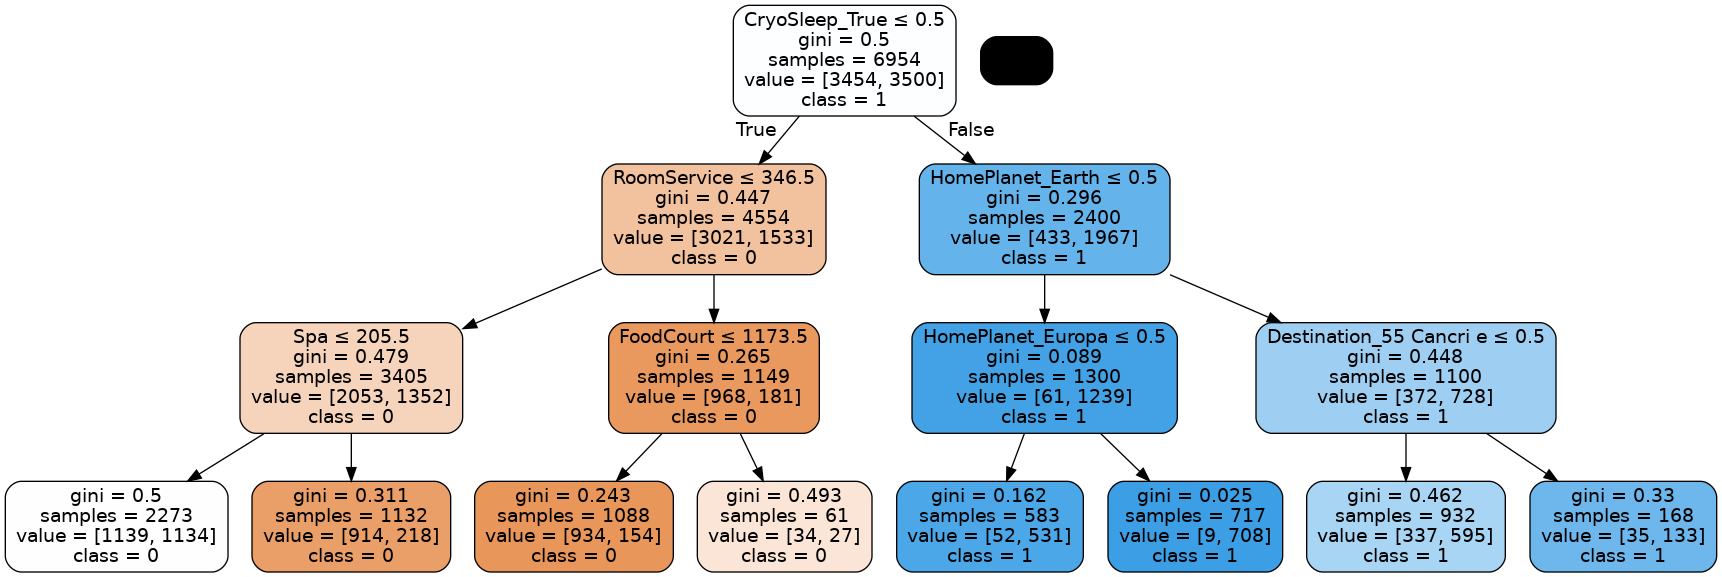

In [125]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

dot_data = export_graphviz(model, out_file=None, feature_names=X.columns, class_names=['0', '1'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [128]:
# salvar o grafico renderizado em um arquivo .png
graph.write_png('tree_1.png')

True

A árvore pode ser interpretada facilmente seguindo o caminho da raiz até as folhas. Cada nó representa uma decisão ou teste em uma característica específica, e cada ramo representa uma possível resposta ou resultado. Os ramos subsequentes continuam a se ramificar com base em novos testes e características até que um nó de folha seja alcançado. Esse nó de folha representa a decisão final ou a previsão para uma determinada amostra.

O primeiro nó, por exemplo, representa a decisão se a pessoa está em `CryoSleep` ou não. O modelo também mostra o índice de Gini em cada nó, que já foi explicado anteriormente. `value` representa a quantidade de amostras em cada classe, e `class` representa a classe predita para cada nó.

Com o modelo pronto e treinado, vamos testá-lo. Antes de treinar, dividimos o dataset aleatoriamente entre treinamento e teste. Agora, vamos utilizar o teste para verificar a acurácia do modelo, além de definir sua matriz de confusão, que representa quantos dados foram corretamente classificados, e quantos foram classificados incorretamente.

In [129]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7222541690626797

In [119]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[740, 121],
       [362, 516]])

Todos esses dados estão resumidos no `classification_report()`, que mostra a precisão, recall, f1-score e suporte para cada classe. O suporte é o número de ocorrências de cada classe no dataset de teste. Para mais informações sobre essas métricas, consulte o artigo em [Statology](https://www.statology.org/sklearn-classification-report/).

In [120]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.86      0.75       861
        True       0.81      0.59      0.68       878

    accuracy                           0.72      1739
   macro avg       0.74      0.72      0.72      1739
weighted avg       0.74      0.72      0.72      1739



Resumindo os dados acima, a precisão da previsão para os dados foi de 67% para quando o passageiro não foi transportado, e 81% para quando o passageiro foi transportado.

### Como melhorar os resultados do modelo?

Existem várias formas possíveis de melhorar um modelo de árvore de decisão:

1. Ajustar os parâmetros do modelo. Podemos aumentar, por exemplo, a profundidade da árvore. Isso pode melhorar a acurácia do modelo, mas também pode causar overfitting, ou seja, o modelo pode se ajustar demais aos dados de treinamento, perdendo a capacidade de generalizar para dados não vistos.
2. Usar um ensemble de árvores de decisão. O ensemble de árvores de decisão (como o Random Forest) é uma técnica que combina vários modelos de árvore de decisão para melhorar o desempenho geral. Cada árvore é treinada em um subconjunto aleatório dos dados de treinamento e, em seguida, as previsões são combinadas por votação para produzir uma previsão final.

As demais técnicas, como seleção de características relevantes e pré-processamento de dados, já foram minimamente aplicadas anteriormente. Aumentar o tamanho do conjunto de dados também não se aplica ao problema.

Uma outra técnica, mais avançada, que poderia ser utilizada, é a validação cruzada. A validação cruzada é uma técnica que permite que o modelo seja treinado e testado em diferentes conjuntos de dados, de forma a evitar o overfitting. Para mais informações sobre validação cruzada, consulte o artigo em [Statology](https://www.statology.org/k-fold-cross-validation/).

### Modelo de Árvore de decisão: profundidade maior

Primeiramente, vamos trabalhar com o mesmo modelo utilizado anteriormente, porém alterando seus parâmetros, como `max_depth` e `min_samples_leaf`. O `max_depth` define a profundidade máxima da árvore, enquanto o `min_samples_leaf` define o número mínimo de amostras necessárias para que um nó seja considerado uma folha. Trabalharemos com 5 para ambos os parâmetros, tentando encontrar um equilíbrio entre a acurácia do modelo e o overfitting.

In [130]:
model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

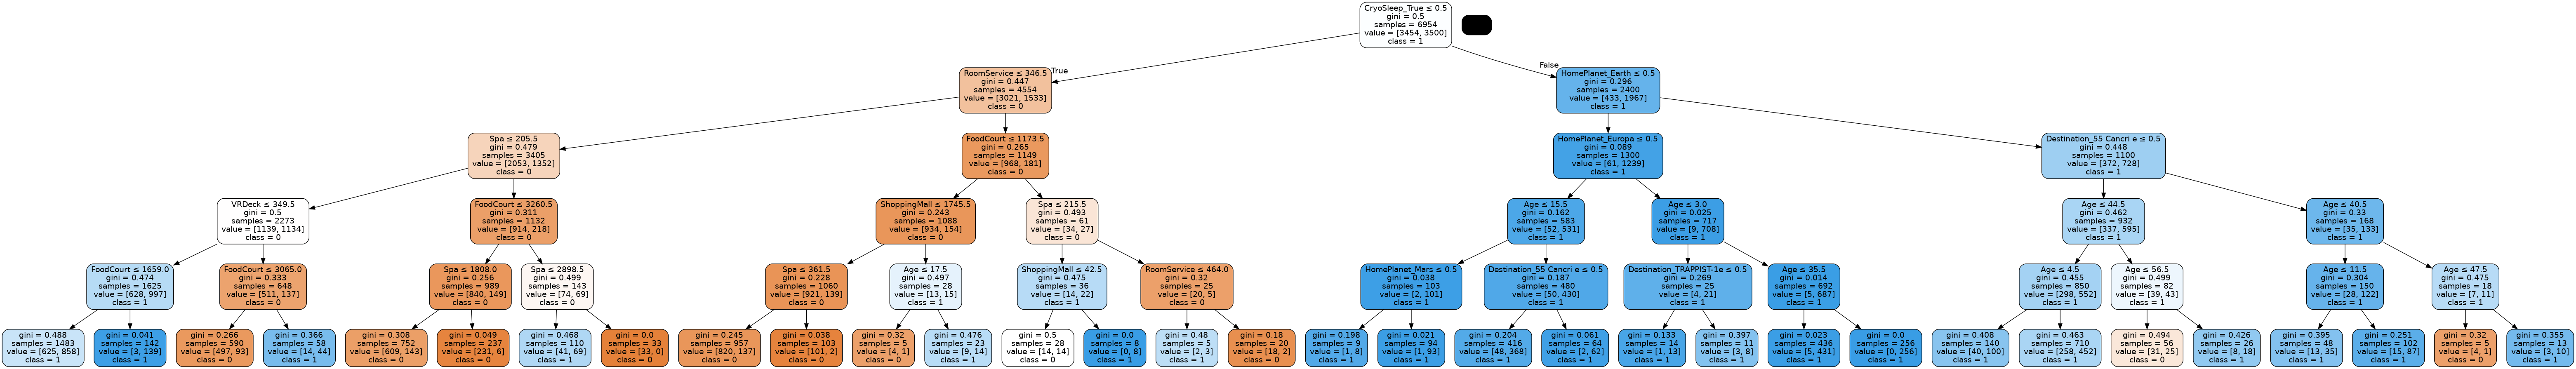

In [137]:
dot_data = export_graphviz(model, out_file=None, feature_names=X.columns, class_names=['0', '1'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [138]:
graph.write_png("tree_model_2.png")

True

Como podemos ver, o modelo ficou muito mais complexo, com mais nós e folhas, se tornando mais difícil acompanhar a sequência dos dados para a tomada de decisão. A renderização, porém, segue o mesmo modelo do descrito anteriormente.

In [133]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7625071880391029

In [134]:
confusion_matrix(y_test, y_pred)

array([[570, 291],
       [122, 756]])

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.66      0.73       861
        True       0.72      0.86      0.79       878

    accuracy                           0.76      1739
   macro avg       0.77      0.76      0.76      1739
weighted avg       0.77      0.76      0.76      1739



Como podemos observar, a acurácia do modelo foi modificada. Conseguimos melhorá-la, melhorando a precisão do modelo em prever quando um resultado para passageiro transportado é falso (82%) e quando é verdadeiro (72%). A acurácia melhorou em 4%.

É importante notar que, como o modelo e os testes utilizam estados aleatórios, os resultados podem variar de acordo com a execução do código. Para garantir que os resultados sejam os mesmos, é possível definir um estado aleatório para o modelo, utilizando o parâmetro `random_state`.

### Modelo de Árvore de decisão: ensemble
### Random Forest

Agora vamos utilizar o modelo de Random Forest para tentar melhorar a acurácia do modelo.

O modelo Floresta Aleatória (Random Forest) pode ser considerado relativamente explicável, mas nem tanto quanto uma única árvore de decisão.

A Floresta Aleatória é composta por várias árvores de decisão que trabalham em conjunto para produzir uma previsão final. Cada árvore é treinada em um subconjunto aleatório dos dados de treinamento e um subconjunto aleatório das características de entrada. Essa aleatoriedade ajuda a reduzir o overfitting e melhorar o desempenho geral do modelo.

Uma vantagem da Floresta Aleatória é que ela pode fornecer medidas de importância de recurso (feature importance) para ajudar a entender quais características de entrada são mais importantes para a previsão. Isso pode ajudar a explicar como o modelo está tomando decisões e fornecer insights sobre o processo de tomada de decisão.

Além disso, a Floresta Aleatória pode ser visualizada como um conjunto de árvores de decisão. Cada árvore pode ser representada visualmente como uma árvore de decisão padrão, o que pode ajudar a entender como cada árvore está contribuindo para a previsão final.

No entanto, a Floresta Aleatória ainda pode ser menos explicável do que alguns outros modelos devido à sua complexidade e ao fato de que a previsão final é uma combinação das previsões de várias árvores de decisão.

O modelo treina várias árvores de decisão e, em seguida, combina as previsões de cada árvore para produzir uma previsão final. Cada árvore é treinada em um subconjunto aleatório dos dados de treinamento e um subconjunto aleatório das características de entrada. Essa aleatoriedade ajuda a reduzir o overfitting e melhorar o desempenho geral do modelo.

A decisão final é tomada por votação, onde cada árvore vota por uma classe e a classe com o maior número de votos é considerada a previsão final.

Primeiramente, vamos utilizar um modelo que treinará 5 árvores de profundidade máxima 3 e com 5 amostras mínimas para serem consideradas folhas. Normalmente, um modelo de Floresta Aleatória é treinado com 50 ou mais árvores, mas para fins de demonstração, vamos utilizar apenas 5 árvores.

In [152]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_leaf=5, random_state=0)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5, n_estimators=5,
                       random_state=0)

In [153]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7291546866014951

In [154]:
confusion_matrix(y_test, y_pred)

array([[728, 133],
       [338, 540]])

In [155]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.68      0.85      0.76       861
        True       0.80      0.62      0.70       878

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.73      1739



In [156]:
feature_importances = pd.DataFrame(model.feature_importances_, index = x_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
CryoSleep_True,0.393931
CryoSleep_False,0.136816
Spa,0.128225
VRDeck,0.106557
RoomService,0.054899
HomePlanet_Europa,0.052200
ShoppingMall,0.048697
FoodCourt,0.039809
HomePlanet_Earth,0.027414
Destination_55 Cancri e,0.009963


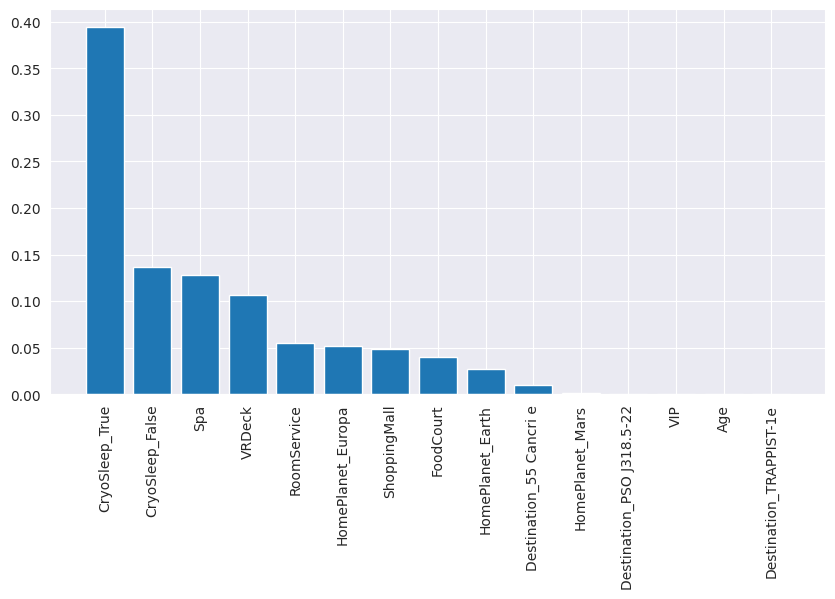

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(feature_importances.index, feature_importances['importance'])
plt.xticks(rotation=90)
plt.show()

Como já dito anteriormente, uma feature importante do modelo Random Forest é definir quais features são mais importantes para a tomada de decisão. Para isso, utilizamos o método `feature_importances_` do modelo, que retorna um array com a importância de cada feature. Para facilitar a visualização, criamos um gráfico de barras com as features e suas importâncias.

Assim, podemos ver, por exemplo, que se um passageiro está em `CryoSleep` ou é uma feature importante para a tomada de decisão, enquanto `Age` não é uma variável relevante. Podemos, então, utilizar esse resultado para treinar um novo modelo, removendo as features de menor importância.

In [158]:
try:
    x_train_ = x_train.drop(['Age', 'VIP'], axis=1)
    x_test_ = x_test.drop(['Age', 'VIP'], axis=1)
except:
    pass

In [159]:
model = RandomForestClassifier(n_estimators=5, max_depth=3, min_samples_leaf=5, random_state=0)

model.fit(x_train_, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5, n_estimators=5,
                       random_state=0)

In [160]:
y_pred = model.predict(x_test_)
accuracy_score(y_test, y_pred)

0.7326049453709028

In [161]:
confusion_matrix(y_test, y_pred)

array([[721, 140],
       [325, 553]])

In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.69      0.84      0.76       861
        True       0.80      0.63      0.70       878

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.73      1739



A acurácia do modelo melhorou, mas não foi significativamente. Vamos, então, aumentar o número de árvores para 100, aumentando também a profundidade máxima da árvore. Com isso, o modelo se torna ainda menos explicável, pois para chegarmos na tomada de decisão, precisaríamos analisar o resultado de 100 diferentes árvores para, então, realizar a votação e chegar na decisão final. Como o modelo é mais complexo, também é mais difícil de visualizar.

In [175]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=0)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=0)

In [176]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7763082231167338

In [177]:
confusion_matrix(y_test, y_pred)

array([[683, 178],
       [211, 667]])

In [178]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.76      0.79      0.78       861
        True       0.79      0.76      0.77       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [179]:
feature_importances = pd.DataFrame(model.feature_importances_, index = x_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
CryoSleep_False,0.193729
CryoSleep_True,0.185179
Spa,0.139115
VRDeck,0.111294
RoomService,0.110059
FoodCourt,0.072147
ShoppingMall,0.057003
HomePlanet_Earth,0.046830
HomePlanet_Europa,0.037378
Age,0.022101


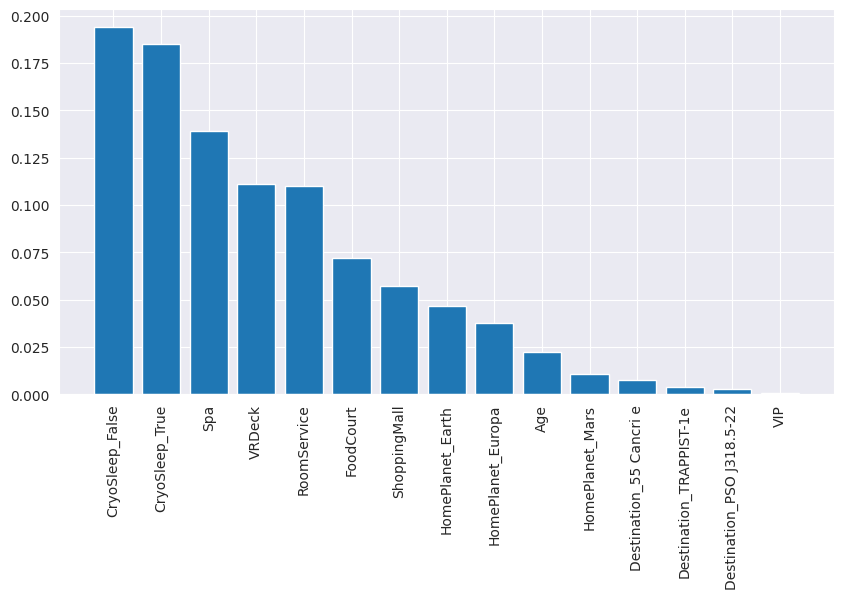

In [180]:
plt.figure(figsize=(10, 5))
plt.bar(feature_importances.index, feature_importances['importance'])
plt.xticks(rotation=90)
plt.show()

In [185]:
try:
    x_train_ = x_train.drop(['VIP', 'Destination_TRAPPIST-1e', 'Destination_PSO J318.5-22', 'Destination_55 Cancri e'], axis=1)
    x_test_ = x_test.drop(['VIP', 'Destination_TRAPPIST-1e', 'Destination_PSO J318.5-22', 'Destination_55 Cancri e'], axis=1)
except:
    pass

In [186]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5, random_state=0)

model.fit(x_train_, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=0)

In [187]:
y_pred = model.predict(x_test_)
accuracy_score(y_test, y_pred)

0.777458309373203

In [188]:
confusion_matrix(y_test, y_pred)

array([[656, 205],
       [182, 696]])

In [189]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.78      0.76      0.77       861
        True       0.77      0.79      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



Após reformular o modelo para mais árvores de decisão, aumentar a profundidade máxima e remover as features com importância menor a 0.01, a acurácia do modelo melhorou significativamente, com relação à primeira árvore de decisão elaborada, com uma acurácia de 77,76%.

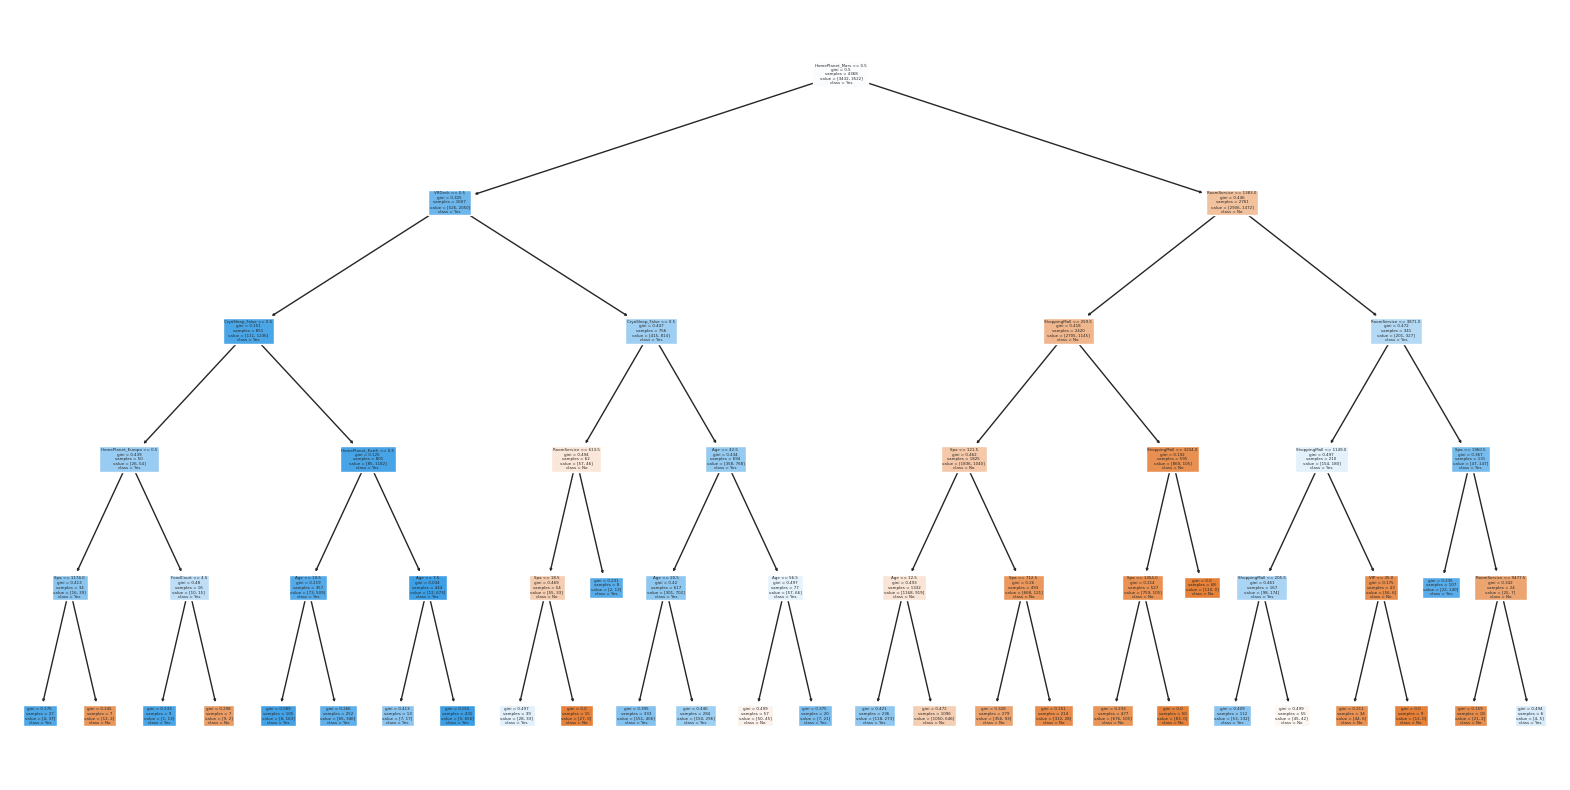

In [193]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=x_train.columns, class_names=['No', 'Yes'], filled=True)
plt.savefig('tree_random_forest.png')
plt.show()

Acima, temos um exemplo de uma das árvores de decisão do modelo. Podemos ver que a árvore foi construída de forma recursiva, onde cada nó representa uma decisão e cada folha representa uma classe. A cor da folha indica a classe que foi escolhida, enquanto a cor do nó indica a classe que foi escolhida naquele nó. A cor mais escura indica que a classe foi escolhida com mais frequência. No modelo como um todo, temos 100 dessas árvores.

# Trabalhando com Regressão Logística

Uma outra técnica de classificação muito utilizada é a Regressão Logística. A Regressão Logística é um modelo de classificação que utiliza uma função logística para realizar a classificação. A função logística é uma função que retorna um valor entre 0 e 1, que pode ser interpretado como uma probabilidade. A Regressão Logística utiliza a função logística para realizar a classificação, onde a probabilidade de uma classe é calculada a partir de uma combinação linear das features. A combinação linear é calculada a partir de uma equação, onde cada feature é multiplicada por um coeficiente e somada a um termo de interceptação. A equação é dada por:

$$\hat{y} = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n)}}$$

Onde $\hat{y}$ é a probabilidade de uma classe, $x_i$ é uma feature, $\beta_i$ é o coeficiente da feature e $\beta_0$ é o termo de interceptação. A partir da probabilidade, é possível realizar a classificação, onde a classe é escolhida a partir de um limiar. Por exemplo, se o limiar for 0.5, a classe será escolhida a partir da probabilidade, onde se a probabilidade for maior que 0.5, a classe será 1, caso contrário, a classe será 0.

Para mais informações sobre o funcionamento de uma regressão logística, recomendo a leitura do artigo [A Gentle Introduction to Logistic Regression for Machine Learning](https://machinelearningmastery.com/logistic-regression-for-machine-learning/).

O processo de modelagem é semelhante ao realizado anteriormente. Vamos seguir à partir da divisão dos dados em treino e teste.

In [194]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [195]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7786083956296722

In [196]:
confusion_matrix(y_test, y_pred)

array([[652, 211],
       [174, 702]])

In [197]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.76      0.77       863
        True       0.77      0.80      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [198]:
feature_importances = pd.DataFrame(model.coef_[0], index = x_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
HomePlanet_Europa,1.151148
CryoSleep_True,0.975333
Destination_55 Cancri e,0.592682
HomePlanet_Mars,0.076416
VIP,0.040846
Destination_PSO J318.5-22,0.016549
FoodCourt,0.000552
ShoppingMall,0.000537
RoomService,-0.001499
VRDeck,-0.001751


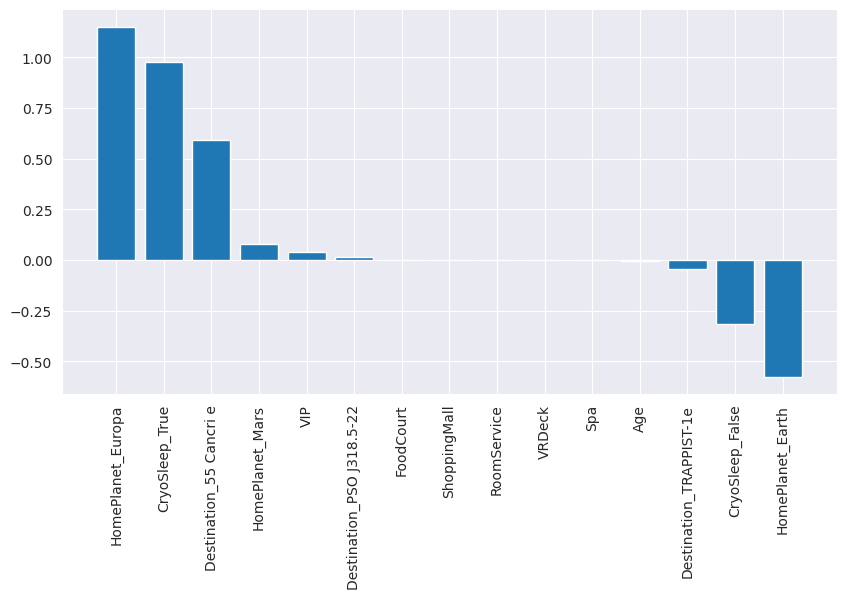

In [199]:
plt.figure(figsize=(10, 5))
plt.bar(feature_importances.index, feature_importances['importance'])
plt.xticks(rotation=90)
plt.show()

Como podemos ver, para o problema em questão, o modelo de regressão logística funciona, a princípio, com uma acurácia melhor que o modelo de árvore de decisão. Com um modelo simples, obtivemos uma acurácia de 77.8%, enquanto após realizarmos diversas otimizações no modelo de árvore, obtivemos 77.7% de acurácia. Se trata praticamente do mesmo resultado, porém utilizando um modelo mais simples.

O modelo de regressão logística, por utilizar uma função logística, é um modelo linear. Assim, como ocorre no modelo de Random Forest, também consegue fornecer as features mais importantes para o modelo, permitindo otimizá-lo para rodar um modelo cuja acurácia pode ser ainda melhor. A importância das features se trata do coeficiente da feature, que é o quanto a feature influencia na classificação.

### Como melhorar o modelo?

1. Verificar e tratar dados ausentes ou nulos: Dados ausentes ou nulos podem levar a resultados imprecisos e prejudicar a precisão do modelo. Portanto, é importante verificar e tratar esses dados antes de treinar o modelo.
2. Seleção de recursos (feature selection): Nem todas as características podem ser importantes para a previsão do modelo. A seleção de recursos ajuda a escolher as características mais relevantes para a previsão, o que pode ajudar a melhorar a precisão do modelo.
3. Engenharia de características (feature engineering): Engenharia de características pode envolver a criação de novas características com base nas características existentes. Isso pode ajudar a extrair informações relevantes dos dados e melhorar a precisão do modelo.
4. Normalização dos dados: Normalizar os dados pode ajudar a melhorar a precisão do modelo, garantindo que as características tenham escalas comparáveis.
5. Regularização: A regularização pode ajudar a reduzir o overfitting e melhorar a precisão do modelo. A regularização pode ser alcançada através de técnicas como L1, L2 ou ElasticNet.
6. Ajuste de hiperparâmetros: Os hiperparâmetros do modelo podem ser ajustados para obter uma precisão melhor. Os hiperparâmetros são ajustados usando técnicas como a validação cruzada.
7. Utilizar técnicas de ensemble: As técnicas de ensemble como o bootstrap aggregating (Bagging) ou a boosting podem melhorar a precisão do modelo de regressão logística, combinando vários modelos de regressão logística em conjunto.
8. Tratamento de dados desbalanceados: Se os dados estiverem desbalanceados (um dos rótulos de classe é muito menos frequente do que o outro), técnicas como oversampling ou undersampling podem ajudar a melhorar a precisão do modelo.

O mais comum para melhorar um modelo de regressão logística é a *Feature Selection* e *Feature Engineering*.